In [1]:
# !pip install numpy seaborn pandas scipy multiprocess multiprocessing

In [2]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

ERR = 1e-10
STARTING_AGE = 20
MAX_EXTRA_YEARS = 120 - STARTING_AGE

# Part 1: The Live-Death Model

## Ultimate Survival Model

Define
$$
\mu_x = A + Bc^x
$$
where $A = 0.00022, B = 2.7\times10^{-6}, c = 1.124$.

Then, let $T$ be the lifespan of a person. We denote
$$
\begin{align*}
    {}_t p_x &= \Pr[T > x+t | T > x] \\
             &= e^{-\int_{s=0}^t \mu_{x+s}} \, ds
\end{align*}
$$
where $x$ is the starting age and $t$ is the number of years left.

In [3]:
from scipy.integrate import quad

def compute_mu(x):
    A = 0.00022
    B = 2.7e-6
    c = 1.124
    return A + B * c**x

def prob_of_living(x0, t):
    """
    x = current age
    t = number of years left
    => Pr[Living another t years | You are x y/o]
    """
    integral_val, _ = quad(lambda s: compute_mu(x0 + s), 0, t)
    return np.exp(-integral_val)

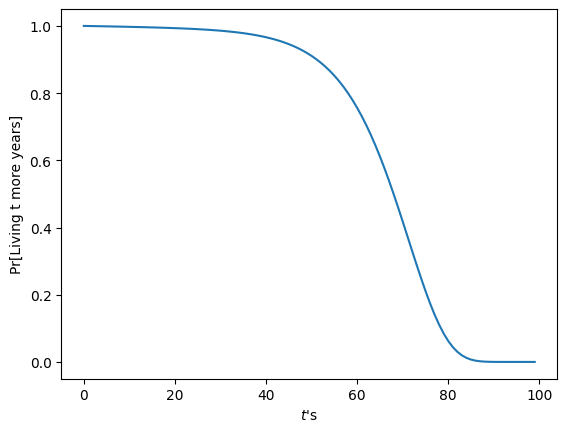

In [4]:
ts = np.arange(0, MAX_EXTRA_YEARS)
ys = np.array([prob_of_living(STARTING_AGE, t) for t in ts])

tp_data = pd.DataFrame({
    "$t$'s": ts,
    "Pr[Living t more years]": ys,
})

sns.lineplot(tp_data, x="$t$'s", y="Pr[Living t more years]")
plt.savefig("../presentation/graphics/plot1.png")

## Modeling this as a Markov Chain

Let $S = \{A \text{(Alive)}, D \text{(Dead)}\}$. Obviously, $D$ is a recurrent state. We want to find the transition probability $A \to D$. Denote

$$
\begin{align*}
{}_k q_x &= \Pr[x+k \leq T \leq x+k+1 | T > x] \\
         &= {}_k p_x - {}_{k+1} p_x
\end{align*}
$$

Lastly, define the sequence of transition matrices $\{P_x(t)\}_{t=0}^\infty$
$$
P_x(t) = \begin{bmatrix}
    1 - {}_t q_x & {}_t q_x \\
    0 & 1
\end{bmatrix}
$$

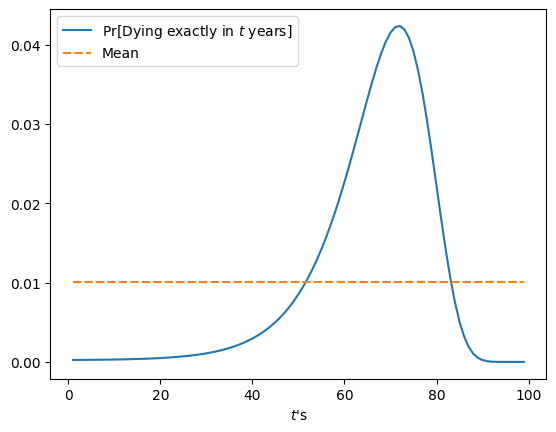

In [5]:
qs = np.array([ys[i-1] - ys[i] for i in range(1, MAX_EXTRA_YEARS)])
qs_mean = np.mean(qs)

tq_data = pd.DataFrame({
    "$t$'s": ts[1:],
    "Pr[Dying exactly in $t$ years]": qs,
    "Mean": qs_mean,
}).set_index("$t$'s")

sns.lineplot(tq_data)
plt.savefig("../presentation/graphics/plot2.png")

Since this computation is rather expensive, we will try to look at alternative ways to compute ${}_t q_x$. Namely, we will try to fit it to some function or a known probability distribution. We have two choices here:
- A function that has a sharp increase and sharp decrease. This is very simple but it will not capture the shape of the curve very well.
- Skew Normal Distribution. This should give us higher precision compared to the simple function but will also be more expensive to compute.

In the end, the simple function used to fit ${}_t q_x$'s is
$$ f(x) = a \cdot \left(e^{-\frac{(x-b)^2}{c}}\right) $$
Yes, ChatGPT gave me this idea but not this exact function.

Obviously, we also tried with the Skew Normal Distribution.

In [6]:
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

def fitting_func(x, a, b, c):
    return a * np.exp(- (x-b)**2 / c)

def sn_fitting_func(x, xi, omg, alpha):
    return skewnorm.pdf(x, xi, omg, alpha)

opt_params, _ = curve_fit(fitting_func, ts[1:], qs)
sn_opt_params, _ = curve_fit(sn_fitting_func, ts[1:], qs, maxfev=10_000)
a0, b0, c0 = opt_params
xi0, omega0, alpha0 = sn_opt_params

fitted_qf = lambda x: fitting_func(x, a0, b0, c0)
sn_fitted_qf = lambda x: sn_fitting_func(x, xi0, omega0, alpha0)

(a0, b0, c0), (xi0, omega0, alpha0)

((0.041507927178874464, 69.53110084513646, 167.6366928196927),
 (-3.339332676700968, 79.36912671695876, 15.835646498702483))

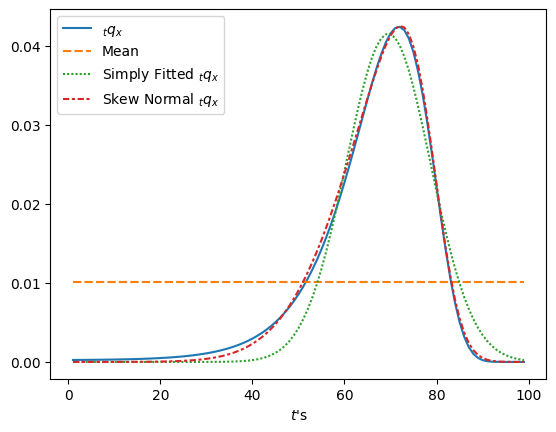

In [7]:
fitting_data = pd.DataFrame({
    "$t$'s": ts[1:],
    "${}_t q_x$": qs,
    "Mean": qs_mean,
    "Simply Fitted ${}_t q_x$": [fitted_qf(t) for t in ts[1:]],
    "Skew Normal ${}_t q_x$": [sn_fitted_qf(t) for t in ts[1:]],
}).set_index("$t$'s")

sns.lineplot(fitting_data)
plt.savefig("../presentation/graphics/plot3.png")

## Expected Time to Live

An easy way out is to just compute
$$
\text{E}[T] = \sum_{t=0}^\infty t \cdot {}_t q_x
$$

Note: The computation here cuts off at around $t$ no more than 100-120 as at that point, the ${}_t q_x$ is so low that it will not contribute much more to the expected value. In fact, it is to the point that the precision is already lost due to floating-point arithmetics.

In [8]:
expected_extra_live = ts[1:] @ qs
expected_extra_live, STARTING_AGE + expected_extra_live

(66.41315159574077, 86.41315159574077)

In [9]:
def compute_q(x0, t):
    t1 = prob_of_living(x0, t)
    t2 = prob_of_living(x0, t - 1)
    return t2 - t1

# Part 2: The General Model

Obviously, people get sick. Once people get sick, they become more likely to die. We will now incorporate this into our model. Specifically, we will only add cancer into this model because just by doing so already increases the complexity by a lot.

Consider the state space $S = \{A, C, D\}$ where $C$ is for cancer (multiple myeoloma, specifcally) and $A$ and $D$ are from before. Additionally define $c_t$ to be the probability of getting cancer at year $t$ and $r_t$ be the probability of recovering from cancer at year $t$.
$$
P = \begin{bmatrix}
    1 - c_t - {}_t q_x & {}_t c_t & {}_t q_x \\
    0 & 1 - d_t & d_t \\
    0 & 0 & 1
\end{bmatrix}
$$
where $c_t$ is the probability of getting cancer at age $x+t$ and $d_t$ is the probability of dying from cancer at age $x+t$. Note that the probability of someone recovering from cancer is 0 because I couldn't find any data on the curing rate of cancer. I still think that it is rather low, however. Note also that this probability is of *all* kinds of cancer, so the probability may vary depending on which variant of cancer you are in. It also does not take into consideration the stage of cancer a patient is in.

## Finding the Rate of Getting Cancer

Although there is probably a USM-like model out there for predicting cancer, I couldn't find it :/
So, we are going to stick with the good old method of *fitting a simple function*. The function in question is
$$
f(x) = a\exp\left({-\frac{(x-b)^2}{c}}\right)
$$
(i.e., the function from before.)

The data is from the [SEER Program, NIH](https://seer.cancer.gov/statistics-network/explorer/application.html?site=1&data_type=1&graph_type=3&compareBy=sex&chk_sex_1=1&rate_type=2&race=1&advopt_precision=1&hdn_view=0) so it is mostly based on U.S. data.

In [10]:
cancer_rate_df = pd.read_csv("data/cancer_diag_rate.csv").drop(["Lower 95% C.I.", "Upper 95% C.I."], axis=1)
cancer_rate_df["Age at Diagnosis"] = cancer_rate_df["Age at Diagnosis"].map(lambda s: int(s.split("-")[-1]))
cancer_rate_df["Rate per 100,000"] = cancer_rate_df["Rate per 100,000"].map(lambda r: r / 100_000)
cancer_rate_df = cancer_rate_df.set_index("Age at Diagnosis")
# cancer_rate_df

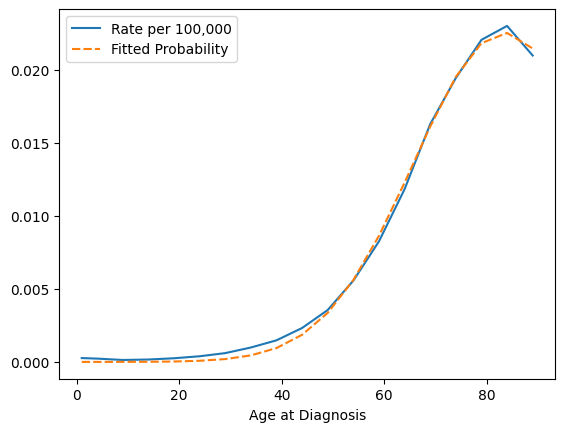

In [11]:
cr_popt, _ = curve_fit(fitting_func, cancer_rate_df.index, cancer_rate_df["Rate per 100,000"])
a1, b1, c1 = cr_popt
cancer_rate_df["Fitted Probability"] = fitting_func(cancer_rate_df.index, a1, b1, c1)

sns.lineplot(cancer_rate_df, color="orange")
plt.savefig("../presentation/graphics/plot4.png")

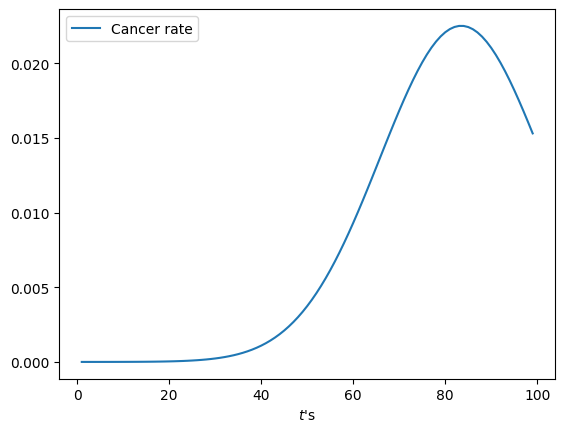

In [12]:
compute_cancer_rate = lambda t: fitting_func(t, a1, b1, c1)  # t is age

cancer_df = pd.DataFrame({
    "$t$'s": ts[1:],
    "Cancer rate": [compute_cancer_rate(t) for t in ts[1:]],
}).set_index("$t$'s")

sns.lineplot(cancer_df)
plt.savefig("../presentation/graphics/plot5.png")

#### Cancer Mortality Rate

Now, we will find the probability of someone with cancer dying based on their age. Similarly, there is probably a better model used in survival analysis for cancer patients. However, I'm out of time and this thing is due like tomorrow so I'm sticking with this. Specifically, we will try to fit a polynomial of degree 4 to the data obtained from [VizHub, Institute for Health Metrics and Evaluation](https://vizhub.healthdata.org/gbd-results/?params=gbd-api-2019-public/d5aa04a7f40e79e9493ec1144e0d0686). Note that we are only fitting with 5 years of data, 2014-2019 to be specific.

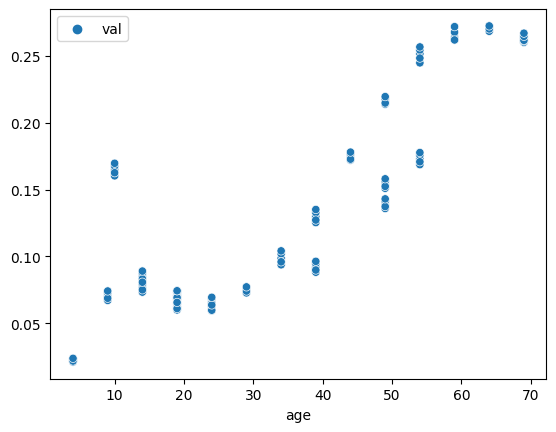

In [13]:
cancer_death_df = pd.read_csv("data/IHME-GBD_2019_DATA-d5aa04a7-1.csv").drop(["upper", "lower", "measure", "location", "sex", "cause", "metric"], axis=1)
cancer_death_df = cancer_death_df.drop(cancer_death_df[cancer_death_df["year"] <= 2014].index)

cancer_death_df["age"] = cancer_death_df["age"].map(lambda s: int(s.split(" ")[0].split("-")[-1]))
cancer_death_df = cancer_death_df.drop(cancer_death_df[cancer_death_df["age"] > 70].index)
cancer_death_df = cancer_death_df.set_index("age").drop(["year"], axis=1)

sns.scatterplot(cancer_death_df)
plt.savefig("../presentation/graphics/plot6.png")

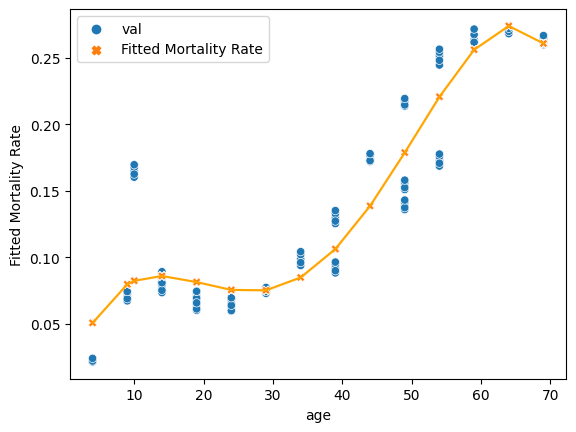

In [14]:
a2, b2, c2, d2, f2 = np.polyfit(cancer_death_df.index, cancer_death_df["val"], 4)
compute_cancer_death = lambda t: np.max([a2*t**4 + b2*t**3 + c2*t**2 + d2*t + f2, 0])  # t is age

cancer_death_df["Fitted Mortality Rate"] = [compute_cancer_death(e) for e in cancer_death_df.index]

sns.scatterplot(cancer_death_df)
sns.lineplot(cancer_death_df["Fitted Mortality Rate"], color="orange")
plt.savefig("../presentation/graphics/plot7.png")

This fit was approved by 7 people and only 1 said that it was bad. By democracy, this is a good fit.

## All the Probabilities

In [15]:
def make_non_decr(arr):
    n = len(arr)
    cache = np.zeros(n)

    cache[0] = arr[0]
    
    for i in range(1, n):
        cache[i] = np.max([arr[i], cache[i-1]])

    return cache

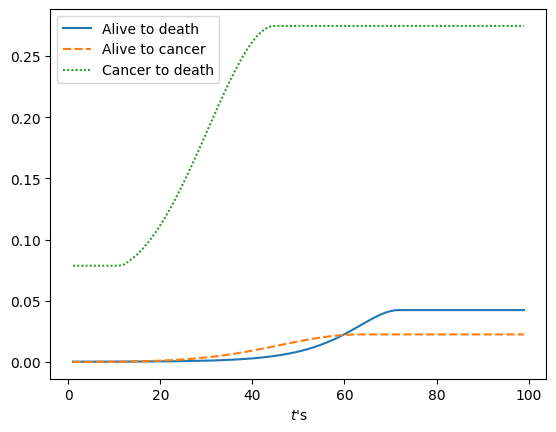

In [16]:
nts = ts[1:]

total_probability = pd.DataFrame({
    "$t$'s": nts,
    "Alive to death": make_non_decr([compute_q(STARTING_AGE, t) for t in nts]),
    "Alive to cancer": make_non_decr([compute_cancer_rate(STARTING_AGE + t) for t in nts]),
    "Cancer to death": make_non_decr([compute_cancer_death(STARTING_AGE + t) for t in nts]),
}).set_index("$t$'s")

sns.lineplot(total_probability)
plt.savefig("../presentation/graphics/plot8.png")

Observe that the probability that you will die at age $t$ given that you have cancer is significantly higher than dying from natural causes. Lesson of the story, *don't get cancer*.

## Generating $P$ Matrices and Simulation

Finally, we want to create a function that can be used to generate the *sequence* of $P$ matrices that stores the transition probability. This will be later used for simulations because I don't wanna do this analytically anymore.

In [17]:
def generate_P(t):
    # t here is for the extra life
    alive_to_death = compute_q(STARTING_AGE, t)
    alive_to_cancer = compute_cancer_rate(t + STARTING_AGE)
    cancer_to_death = compute_cancer_death(t)
    # curing_rate = ...
    
    P = np.array([
        [1 - alive_to_cancer - alive_to_death, alive_to_cancer, alive_to_death],
        # [curing_rate, 1 - curing_rate - cancer_to_death, cancer_to_death],
        [0, 1 - cancer_to_death, cancer_to_death],
        [0, 0, 1],
    ])

    return P

In [18]:
from numpy.random import choice

N = 1_000

In [19]:
def simulate_prob_living_time_once(t0):
    state = 0
    t = 0
    for i in range(t0):
        P = generate_P(t)
        state = choice([0, 1, 2], p=P[state])
        t += 1
    return state != 2

def compute_sim_prob_live_for_another(t0):
    return np.mean([simulate_prob_living_time_once(t0) for _ in range(N)])

compute_sim_prob_live_for_another(0)

1.0

### ***WE LOVE PARALLEL***

In [20]:
import multiprocess as mp

def create_res():
    with mp.Pool(mp.cpu_count()) as pool:
        result = pool.map(compute_sim_prob_live_for_another, ts)
    return result

In [21]:
res_list = create_res()
diff_list = np.array([res_list[i-1] - res_list[i] for i in range(1, MAX_EXTRA_YEARS)])

par_result = pd.DataFrame({
    "$t$'s": ts[1:],
    "Pr[$T$ > t]": res_list[1:],
    "Pr[Dying in exactly next $t$ years]": diff_list,
    "Pr[Living t more years]": ys[1:],
}).set_index("$t$'s")

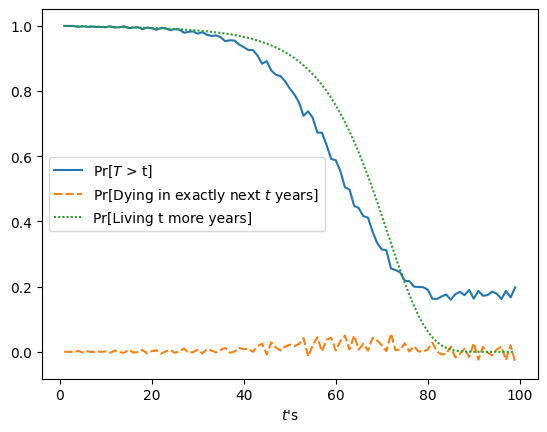

In [22]:
sns.lineplot(par_result)
plt.savefig("../presentation/graphics/plot9.png")

## Expected Time to Die Considering Cancer

In [23]:
expected_dying_with_cancer = par_result.index @ par_result["Pr[Dying in exactly next $t$ years]"]
expected_dying_with_cancer, STARTING_AGE + expected_dying_with_cancer

(46.13100000000001, 66.131)